In [13]:
import meep as mp
import numpy as np

##############################################################################
# 1. 시뮬레이션 기본 파라미터 설정
##############################################################################

resolution = 50     # 1um 당 50픽셀 (약 20nm/픽셀)
dpml = 0.2          # PML 두께(um)

sx = 1.0            # 시뮬레이션 영역 가로 크기(um) - 나노 LED 폭(1,000 nm)이라 가정
sy = 2.5            # 시뮬레이션 영역 세로 크기(um)
cell_size = mp.Vector3(sx, sy, 0)  # 2D 시뮬레이션 (z=0)

pml_layers = [mp.PML(dpml, direction=mp.Y)]

# 소스 파장: 450 nm => 0.45 um
wavelength = 0.45
fcen = 1 / wavelength   # 중심 주파수
df = 0.0                # 단색광 사용

##############################################################################
# 2. 재료(복소수 유전율) 정의
##############################################################################
SiO2  = mp.Medium(epsilon=2.13)
GaN   = mp.Medium(epsilon=6.18)
Al2O3 = mp.Medium(epsilon=3.17)
Ag    = mp.Medium(epsilon=-7.01 + 0.21j)

##############################################################################
# 3. 구조(Geometry) 정의
##############################################################################
# 각 층 두께(um)
t_qw    = 0.01   # QW 10 nm 예시
t_sio2  = 0.07   # 70 nm
t_al2o3 = 0.10   # 100 nm
t_ag    = 0.05   # Ag 층 50 nm 예시 (질문 속 Ag 두께는 정확히 명시 안 됨)

# 레이어 위치(y좌표)
y_qw_center = 0.0
y_qw_min = y_qw_center - t_qw/2
y_qw_max = y_qw_center + t_qw/2

y_sio2_min = y_qw_max
y_sio2_max = y_sio2_min + t_sio2

y_al2o3_min = y_sio2_max
y_al2o3_max = y_al2o3_min + t_al2o3

y_ag_max = y_qw_min
y_ag_min = y_ag_max - t_ag

geometry = [
    # QW (InGaN/GaN 혼합영역이라 가정, 단순화해서 GaN으로)
    mp.Block(
        size=mp.Vector3(sx, t_qw, mp.inf),
        center=mp.Vector3(0, y_qw_center),
        material=GaN
    ),
    # SiO2 Layer
    mp.Block(
        size=mp.Vector3(sx, t_sio2, mp.inf),
        center=mp.Vector3(0, 0.5*(y_sio2_min + y_sio2_max)),
        material=SiO2
    ),
    # Al2O3 Layer
    mp.Block(
        size=mp.Vector3(sx, t_al2o3, mp.inf),
        center=mp.Vector3(0, 0.5*(y_al2o3_min + y_al2o3_max)),
        material=Al2O3
    ),
    # Ag 반사층
    mp.Block(
        size=mp.Vector3(sx, t_ag, mp.inf),
        center=mp.Vector3(0, 0.5*(y_ag_min + y_ag_max)),
        material=Ag
    )
]

##############################################################################
# 4. 소스(Dipole) 정의
##############################################################################
# QW 영역( y=0 인근 )에서 dipole 소스 1개 배치 (2D TM 모드, Ez 사용)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=0.1*fcen),
        component=mp.Ez,
        center=mp.Vector3(0, 0)  # QW 중앙에 배치
    )
]

##############################################################################
# 5. Simulation 객체 생성
##############################################################################
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution
)

##############################################################################
# 6. Flux 모니터 설정 & 추가
##############################################################################
# (1) 소스 주변(Input flux) 모니터 (Dipole 주위)
monitor_in_region = mp.FluxRegion(
    center=mp.Vector3(0, 0),        # 모니터 중심 (QW 중앙 근방)
    size=mp.Vector3(sx, 0, 0)       # x방향 폭: sx, y방향: 0 (1D 선 형태)
)

flux_in = sim.add_flux(
    fcen,   # 중심 주파수
    df,     # 주파수 대역폭
    1,      # 주파수 샘플 개수
    monitor_in_region
)

# (2) Planewave Monitor: QW 상부 1λ(=0.45um) 위쪽
planewave_y = y_al2o3_max + 0.45  # QW 상부에서 0.45 um 정도 떨어진 위치
monitor_out_region = mp.FluxRegion(
    center=mp.Vector3(0, planewave_y),
    size=mp.Vector3(sx, 0, 0)
)

flux_out = sim.add_flux(
    fcen,
    df,
    1,
    monitor_out_region
)

##############################################################################
# 7. 시뮬레이션 실행
##############################################################################
simulation_time = 200  # 충분히 길게
sim.run(until=simulation_time)

##############################################################################
# 8. 모니터 결과 출력
##############################################################################
# get_fluxes() → 각 모니터에서 주파수별 플럭스(여기서는 1개 주파수만)
in_flux_data = mp.get_fluxes(flux_in)
out_flux_data = mp.get_fluxes(flux_out)

p_in  = in_flux_data[0]
p_out = out_flux_data[0]

print(f"Input flux  (P_in): {p_in}")
print(f"Planewave flux (P_out): {p_out}")

##############################################################################
# 9. Far-field/Angle 계산 (추가 예시)
##############################################################################
# ※ 아래는 실제 실행 예시가 아니라, 파-장(Planewave) 모니터로부터
#   farfield 변환을 수행하는 전형적인 패턴입니다.
#   필요에 따라 각도별 E/H field나 방출강도를 산출할 수 있습니다.

# 예) farfield_points = [mp.Vector3( r*np.sin(theta), planewave_y + r*np.cos(theta) )
#                       for theta in np.linspace(-np.pi/2, np.pi/2, 200)]
# ff_data = sim.get_farfield(flux_out, farfield_points)

# ±30° 범위의 방출을 구하려면, theta=-30°~+30° 범위에서 ff_data를 적분/합산하는 방식.


TypeError: '<' not supported between instances of 'complex' and 'int'

In [ ]:
import meep as mp
import matplotlib.pyplot as plt

# 해상도 설정 (픽셀/μm)
resolution = 25

# 두 개의 도파로(waveguide) 너비 설정
w1 = 1.0  # 첫 번째 도파로 너비
w2 = 2.0  # 두 번째 도파로 너비
Lw = 10.0 # 각 도파로의 길이

# 테이퍼(taper) 길이 설정 (2의 거듭제곱)
Lts = [2**m for m in range(4)]

# 공기 영역 및 PML(완전매칭층) 설정
dair = 3.0        # 공기 영역 길이
dpml_x = 6.0      # x 방향 PML 길이
dpml_y = 2.0      # y 방향 PML 길이

# 전체 시뮬레이션 영역 크기 계산
dy = dpml_y + dair + w2 + dair + dpml_y  # y 방향 전체 길이

# 실리콘(Si) 유전율 설정
target_material = mp.Medium(epsilon=12.0)

# 경계층 (PML 적용)
boundary_layers = [mp.PML(dpml_x, direction=mp.X),
                   mp.PML(dpml_y, direction=mp.Y)]

# 모드 주파수 설정 (중심 파장 lcen과 주파수 fcen)
lcen = 6.67
fcen = 1 / lcen

# 시뮬레이션 대칭성 설정
symmetries = [mp.Mirror(mp.Y)]

# 반사율 결과 저장 리스트
R_coeffs = []  # 반사 계수 (eigenmode coefficient 기반)
R_flux = []    # 반사 플럭스 (flux 기반)

# 각 taper 길이에 대해 반복 실행
for Lt in Lts:
    # x 방향 전체 크기 계산
    sx = dpml_x + Lw + Lt + Lw + dpml_x
    cell_size = mp.Vector3(sx, dy, 0)

    # 소스(source) 위치 설정 (입사 모드 생성)
    src_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.2 * Lw)
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen, fwidth=0.2 * fcen),
                                  center=src_pt,
                                  size=mp.Vector3(y=dy - 2 * dpml_y),
                                  eig_match_freq=True,
                                  eig_parity=mp.ODD_Z + mp.EVEN_Y)]

    # 첫 번째 시뮬레이션 (직선 도파로)
    vertices = [mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
                mp.Vector3(0.5 * sx + 1, 0.5 * w1),
                mp.Vector3(0.5 * sx + 1, -0.5 * w1),
                mp.Vector3(-0.5 * sx - 1, -0.5 * w1)]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=[mp.Prism(vertices, height=mp.inf, material=target_material)],
                        sources=sources,
                        symmetries=symmetries)

    # 모니터 위치 설정 (입사 파워 측정)
    mon_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.7 * Lw)
    flux = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=dy - 2 * dpml_y)))

    # 필드가 충분히 감소할 때까지 시뮬레이션 실행
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    # 입사 모드 및 플럭스 데이터 저장
    res = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    incident_coeffs = res.alpha
    incident_flux = mp.get_fluxes(flux)
    incident_flux_data = sim.get_flux_data(flux)

    # 시뮬레이션 초기화
    sim.reset_meep()

    # 두 번째 시뮬레이션 (테이퍼 포함 도파로)
    vertices = [mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
                mp.Vector3(-0.5 * Lt, 0.5 * w1),
                mp.Vector3(0.5 * Lt, 0.5 * w2),
                mp.Vector3(0.5 * sx + 1, 0.5 * w2),
                mp.Vector3(0.5 * sx + 1, -0.5 * w2),
                mp.Vector3(0.5 * Lt, -0.5 * w2),
                mp.Vector3(-0.5 * Lt, -0.5 * w1),
                mp.Vector3(-0.5 * sx - 1, -0.5 * w1)]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=[mp.Prism(vertices, height=mp.inf, material=target_material)],
                        sources=sources,
                        symmetries=symmetries)

    # 반사율 계산을 위한 플럭스 추가
    flux = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=dy - 2 * dpml_y)))
    sim.load_minus_flux_data(flux, incident_flux_data)

    # 필드가 충분히 감소할 때까지 실행
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    # 반사 모드 및 플럭스 데이터 수집
    res = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    taper_coeffs = res.alpha
    taper_flux = mp.get_fluxes(flux)

    # 반사 계수 (eigenmode coefficient 기반) 계산
    R_coeffs.append(abs(taper_coeffs[0, 0, 1])**2 / abs(incident_coeffs[0, 0, 0])**2)
    
    # 반사 플럭스 기반 반사율 계산
    R_flux.append(-taper_flux[0] / incident_flux[0])
    
    # 결과 출력
    print("refl:, {}, {:.8f}, {:.8f}".format(Lt, R_coeffs[-1], R_flux[-1]))


-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00272393 s
Working in 2D dimensions.
Computational cell is 33 x 12 x 0 with resolution 25
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-17.5,0.5,0)
          (17.5,0.5,0)
          (17.5,-0.5,0)
          (-17.5,-0.5,0)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.420378 s
-----------
MPB solved for frequency_1(0.519356,0,0) = 0.176186 after 9 iters
MPB solved for frequency_1(0.424206,0,0) = 0.149878 after 7 iters
MPB solved for frequency_1(0.424377,0,0) = 0.149925 after 5 iters
MPB solved for frequency_1(0.424377,0,0) = 0.149925 after 1 iters
field decay(t = 50.02): 7.547409316620061e-08 / 7.547409316620061e-08 = 1.0
on time step 4294 (time=85.88), 0.000931703 s/step
field decay(t = 100.04): 0.001735614282344119 / 0.001735614282344119 = 1.0
field decay(t =

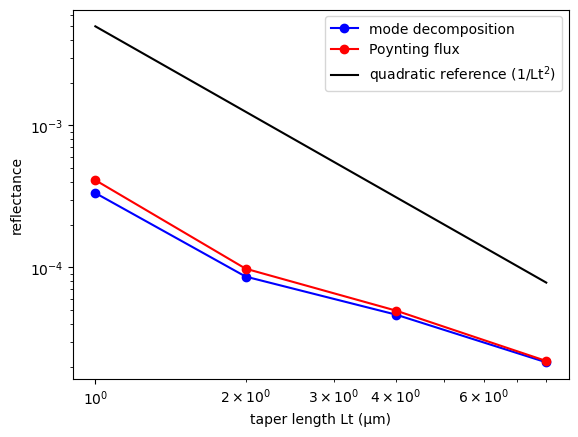

In [ ]:
# 그래프 플로팅 (마스터 프로세스에서만 실행)
if mp.am_master():
    plt.figure()
    plt.loglog(Lts, R_coeffs, 'bo-', label='mode decomposition')  # 고유 모드 분해 기반 반사율
    plt.loglog(Lts, R_flux, 'ro-', label='Poynting flux')  # 포인팅 플럭스 기반 반사율
    plt.loglog(Lts, [0.005/Lt**2 for Lt in Lts], 'k-', label=r'quadratic reference (1/Lt$^2$)')  # 기준 곡선
    plt.legend(loc='upper right')  # 범례 위치 설정
    plt.xlabel('taper length Lt (μm)')  # x축 라벨
    plt.ylabel('reflectance')  # y축 라벨
    plt.show()  # 그래프 출력